# Limpieza de PointsData-Mesh Clients

Eventualmente el objetivo del proyecto en general es encontrar una forma de determinar si los Mesh Clients pueden comunicar o no, en determinadas regiones geográficas y bajo ciertas condiciones de RF. Los MR también tienen tal posibilidad de análisis, pero el principal interés es sobre los MC. Determinar que la referencia geográfica sea correcta parece importante dado que tal información será condicionante al momento del entrenamiento de los algoritmos. La cantidad de datos crece considerablemente con respecto a los MG y MR, por tal motivo se utilizará un enfoque basado en el aprendizaje de máquina para encontrar los valores atípicos.

In [60]:
#Importando librerías
import os
import re
import sys
import utm
sys.path.append('../')
from Python.Preprocessing.funcs import *
from Python.FeatureEngeeniering.Fresnel.fresnelFeature import cord2disV2
import plotly.express as px
import warnings
import json
import matplotlib.pyplot as plt
import plotly
import pandas as pd
import pickle
from datetime import datetime
from Python.Style.styles import  *
from Python.Preprocessing.funcs import  *
from sklearn.ensemble import IsolationForest
import seaborn as sns
import plotly.graph_objs as go
from ipywidgets import interact, widgets, Output
from Python.Preprocessing.mapFuncs import Rdiscrete_map, Rdiscrete_map2, Rdiscrete_map3


In [61]:
warnings.filterwarnings("ignore")

In [62]:
pd.set_option('display.float_format',  '{:,.8f}'.format)

In [63]:
#Utilizando diseño base 1
plt.style.use('../Python/Style/style1.mplstyle')

In [64]:
#Colores base
#Diseño base
mClr = designC['cs']
mClr_d2 = plt.get_cmap('cs-d')(2)
sClr1 = designC['nr']
sClr1_d2 = plt.get_cmap('nr-d')(2)
sClr3 = designC['az']
sClr2 = designC['gr']
sClr2_d = plt.get_cmap('gr-d')(0)
sClr2_d2 = plt.get_cmap('gr-d')(2)
sClr4 = designC['vr']
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

In [65]:
#Datos base desde Data Mart
cContainer = pd.read_parquet("../Data/DataMart/Base/cContainer.parquet")
rContainer = pd.read_parquet("../Data/DataMart/Base/tRContainer.parquet")

In [66]:
#Información de rondas
roundsDf = pd.read_parquet("../Data/DataLake/roundsControl/roundsDf.parquet")

In [ ]:
#Datos de mesh clients
#Leyendo datos de procesamiento automático
prqFiles2 = getNames(r"../Data/DataLake/pointsData",".json")

jdf = pd.DataFrame({'path':prqFiles2, 'name' : ['']*len(prqFiles2)})

jdf["dType"] = jdf["path"].str.extract("([a-z]+)-")

jdf["fDate"] = jdf["path"].str.extract("([0-9]+.[0-9]+.[0-9]+)")

#Creando mcContainer
mList = jdf[jdf["dType"]=="meters"]["path"]
mContainer = createContainer(mList,".json")
mContainer.head(3)

In [68]:
#Información de mContainer
print("Cantidad de filas de mContainer :", len(mContainer))
print("Cantidad de mesh clients :", len(mContainer["radio"].unique()))

Cantidad de filas de mContainer : 1734513
Cantidad de mesh clients : 21186


In [69]:
#Preparando columnas y agregando ronda
pattern = r"([0-9]{4}-[0-9]{2}-[0-9]{2})"
mContainer["fDate"] = mContainer["fName"].str.extract(pattern)
mContainer["fDate"] = pd.to_datetime(mContainer["fDate"], format = "%Y-%m-%d")
mContainer["fDate"] = mContainer["fDate"].dt.date
mContainer["fDate"] = pd.to_datetime(mContainer["fDate"])
mContainer.fDate
#Agregando columna de ronda
for i, row in roundsDf.iterrows():
    mask = (mContainer["fDate"] >= row["fDate"]) & (mContainer["fDate"] < row["lDate"])
    mContainer.loc[mask,"round"] = row["round"]
#Redondeando coordenadas
mContainer["latitude"] = mContainer["latitude"].round(8)
mContainer["longitude"] = mContainer["longitude"].round(8)

In [70]:
#Eliminando MC que no cumplan con regex
print("Cantidad de filas de mContainer :", len(mContainer))
print("Cantidad de mesh clients :", len(mContainer["meterNo"].unique()))
mcPattern = r"^[A-Z]-[0-9]{5}$"
mContainer = mContainer[mContainer["meterNo"].str.match(mcPattern)]
print("Cantidad de filas de mContainer luego del filtro:", len(mContainer))
print("Cantidad de mesh clients luego del filtro:", len(mContainer["meterNo"].unique()))

Cantidad de filas de mContainer : 1734513
Cantidad de mesh clients : 21186
Cantidad de filas de mContainer luego del filtro: 1733505
Cantidad de mesh clients luego del filtro: 21174


In [71]:
#Mesh Clients sin coordenadas
mContainer.rename({"name":"status"}, axis=1, inplace=True)
mCnCords = mContainer[(mContainer["latitude"].isna() | mContainer["longitude"].isna())]
print("Filas sin coordenadas: ",len(mCnCords))
print("MC sin coordenadas: ",len(mCnCords["radio"].unique()))

Filas sin coordenadas:  188644
MC sin coordenadas:  3310


Existen distintas razones por las que los mesh clients podrían no tener coordenadas, sea por omisión, que el equipo no esté instalado en el terreno o algún fallo en los procesos de carga automática de coordenadas que existen en la asignación de estos valores a la base de datos del sistema gestor de la red mesh.

Será necesario utilizar información adicional para intentar verificar lo que se mencionó antes. Así como visualizaciones que permitan entender las causas y acciones correspondientes según los casos generales identificados. En este punto se complica la verificación individual de cada caso dado la cantidadad de los datos.

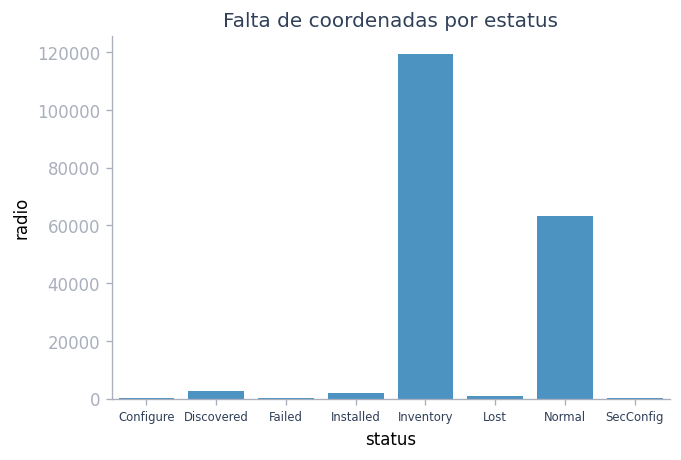

In [72]:
#Gráfica de vacíos segun estatus en el sistema
#sns.set_style("whitegrid")
plt.title("Falta de coordenadas por estatus")
plt.xticks(fontsize=7, color = sClr3)
sns.barplot(mCnCords[["status","radio"]].groupby("status").count().reset_index(),\
            x = "status", y = "radio", color = mClr)
plt.show()

La cantidad significativamente mayor de MC en estado "inventory" puede deberse a equipos que no han sido desplegados en el terreno. Para dilucidar esto se requiere de una fuente externa de datos que contenga una etiqueta que indique si un MC está siendo utilizado por algún cliente o no.

In [73]:
#Solo necesaria UNA ejecución inicial ...
# #Leyendo referencia de montaje
# #Datos de mesh clients
# #Leyendo datos de procesamiento automático
# prqFiles3 = getNames(r"../Data/DataLake/cFiles/montaje/",".XLSX")
# jdf = pd.DataFrame({'path':prqFiles3, 'name' : ['']*len(prqFiles3)})
# jdf["path"] = jdf["path"].astype(str)
# #Creando mcContainer
# montRef = createContainer(prqFiles3,".xlsx")
# #Agregando fecha
# montRef["fDate"] = montRef["fName"].str.extract("([0-9]+-[0-9]+-[0-9]+)")
# montRef.to_parquet("../Data/DataLake/cFiles/montaje/montRef-s1.parquet")
# montRef.head()

In [74]:
# #Filtrando por columna Material
# print("Filas en montRef: ",len(montRef))
# tPattern  = r"41-03"
# montRef["Material"] = montRef["Material"].astype(str)
# montRef = montRef[montRef["Material"].str.contains(tPattern)]
# print("Filas en montRef después del filtro: ",len(montRef))

In [75]:
# #Seleccionando columnas de interés
# montRef = montRef[["Número de serie","Status del sistema","Lote","Fecha de montaje"\
#                    ,"Fecha de desmontaje","Válido de","Empl.equipo modif.el","fName","fDate"]]
# montRef.head(3)

In [76]:
# #Renombrando columnas
# montRef.rename({"Número de serie":"meterNo","Status del sistema":"SStatus",\
#                 "Fecha de montaje":"mntDate","Fecha de desmontaje":"dmntDate",\
#                 "Válido de":"valido","Empl.equipo modif.el":"mod", "fDate":"fDate_mr"}, axis=1, inplace=True)
# montRef.head(3)

In [77]:
# #Guardando de manera temporal
# montRef["fDate_mr"] = pd.to_datetime(montRef["fDate_mr"], format = "%d-%m-%y")
# montRef = montRef.sort_values(by = ["meterNo","fDate_mr"], ascending = [False, True])
# #montRef.to_parquet("../Data/DataLake/cFiles/montaje/montRef.parquet")
# #montRef.to_csv("../Data/DataLake/cFiles/montaje/montRef.csv")

In [78]:
#Leyendo montRef
montRef = pd.read_parquet("../Data/DataLake/cFiles/montaje/montRef.parquet")

In [79]:
#Agregando información de montaje a mCnCords
montRef = montRef.sort_values(by = "fDate_mr", ascending = True)
mCnCords = pd.merge_asof(mCnCords,montRef.drop("fName", axis = 1), left_on = "fDate",\
                          right_on = "fDate_mr", by = "meterNo", suffixes = ("","_mr"), direction = "forward")#, by = "meterNo", direction = "nearest"
mCnCords.to_csv("../Data/DataLake/temp/tempCheck.csv", index = False)

In [80]:
#Check point
#mContainer.to_parquet("../Data/DataLake/temp/mContainer.parquet")
#mCnCords.to_parquet("../Data/DataLake/temp/mCnCords.parquet")

#mContainer = pd.read_parquet("../Data/DataLake/temp/mContainer.parquet")
#mCnCords = pd.read_parquet("../Data/DataLake/temp/mCnCords.parquet")

La información contenida en las referencias de montRef indica de manera aproximada la fecha en que se puso un mesh client en funcionamiento en el terreno. Será necesario identificar las posibles combinaciones de estados de MC y estados en el sistema para determinar cuales de los MC se pueden descartar completamente porque nunca estuvieron desplegados durante el tiempo de la adquisición de datos, y cuales requieren algún tratamiento adicional porque fueron instalados o retirados en el mismo período.

In [81]:
#Posiblemente mantener
#Validando con conjunto principal de datos
print("Cantidad de filas de mCnCords :", len(mCnCords))
print("Cantidad de MC en mCnCords :", len(mCnCords["meterNo"].unique()))
mCwCords = list(mContainer[(~mContainer["latitude"].isna() | ~mContainer["longitude"].isna())]\
                .meterNo.unique())
#Retirando mCwCords de mCnCords
intNC = set(mCwCords).intersection(set(mCnCords.meterNo.unique()))
mCnCords = mCnCords[~mCnCords["meterNo"].isin(intNC)]
print("Cantidad de filas de mCnCords luego del filtro :", len(mCnCords))
print("Cantidad de MC en mCnCords luego del filtro :", len(mCnCords["meterNo"].unique()))
mCnCords.to_csv("../Data/DataLake/temp/mCnCords_toFill.csv", index = False)

Cantidad de filas de mCnCords : 188644
Cantidad de MC en mCnCords : 3310
Cantidad de filas de mCnCords luego del filtro : 161006
Cantidad de MC en mCnCords luego del filtro : 2092


In [ ]:
# Identificando combinaciones existentes
tprove = mCnCords.copy()
tprove["InvSt"] = "Inventory"
tprove.loc[tprove["status"] != "Inventory", "InvSt"] = "NoInventory"
#Agrupando
tprove["iStatus"] = tprove["InvSt"].astype(str) + "-" + tprove["SStatus"].astype(str)
resumen = tprove.groupby(["meterNo","iStatus"]).size().unstack(fill_value=0).reset_index()
#Sumando total
resumen["total"] = resumen.drop("meterNo", axis = 1).sum(axis = 1)
#Guardando resumen
resumen.to_csv("../Data/DataLake/temp/resSec.csv", index = False)
resumen.head()


Con el código anterior se han identificado las secuencias que un MC tiene en cuanto a estatus en el sistema de la red y la referencias de montaje. Las distintas secuencias identificadas pueden ayudar a dilucidar si los equipos estuvieron en funcionamiento en determinado intervalo de tiempo o no.

In [83]:
# #Anadido eliminar
# #Validando con conjunto principal de datos
# print("Cantidad de filas de mCnCords :", len(mCnCords))
# print("Cantidad de MC en mCnCords :", len(mCnCords["meterNo"].unique()))
# mCwCords = list(mContainer[(~mContainer["latitude"].isna() | ~mContainer["longitude"].isna())]\
#                 .meterNo.unique())
# #Retirando mCwCords de mCnCords
# intNC = set(mCwCords).intersection(set(mCnCords.meterNo.unique()))
# mCnCords = mCnCords[~mCnCords["meterNo"].isin(intNC)]
# print("Cantidad de filas de mCnCords luego del filtro :", len(mCnCords))
# print("Cantidad de MC en mCnCords luego del filtro :", len(mCnCords["meterNo"].unique()))
# mCnCords.to_csv("../Data/DataLake/temp/mCnCords_toFill.csv", index = False)

In [84]:
#Validando length
print("Cantidad de filas de mCnCords :", len(mCnCords))
#Medidores no servicio
mnService = []
mnService = mnService + list(resumen[resumen["Inventory-ALMA"] == 84].meterNo.unique())
mnService = mnService + list(resumen[resumen["Inventory-DISP"] == 84].meterNo.unique())
mnService = mnService + list(resumen[resumen["Inventory-DISP NOAC PTBO"] == 84].meterNo.unique())
#Combinaciones sumadas
#mnService = mnService + list(resumen[resumen["Inventory-ALMA"] + resumen["Inventory-DISP"] == 84]\
#                            .meterNo.unique())
mnService = mnService + list(resumen[resumen["Inventory-ALMA"] + resumen["Inventory-DISP NOAC PTBO"] == 84]\
                            .meterNo.unique())
mnService = mnService + list(resumen[resumen["Inventory-DISP"] + resumen["Inventory-DISP NOAC PTBO"] == 84]\
                            .meterNo.unique())
mnService = mnService + list(resumen[resumen["Inventory-ALMA"] + resumen["Inventory-DISP"] + resumen\
                                    ["Inventory-DISP NOAC PTBO"] == 84].meterNo.unique())
#Totales distintos de 84
mnService = mnService + list(resumen[resumen["Inventory-ALMA"] == resumen["total"]].meterNo.unique())
#mnService = mnService + list(resumen[resumen["Inventory-DISP"] == resumen["total"]].meterNo.unique())
mnService = mnService + list(resumen[resumen["Inventory-DISP NOAC PTBO"] == resumen["total"]].meterNo.unique())
mnService = mnService + list(resumen[resumen["Inventory-ALMA"] + resumen["Inventory-DISP"] ==\
                                    resumen["total"]].meterNo.unique())
mnService = mnService + list(resumen[resumen["Inventory-ALMA"] + resumen["Inventory-DISP NOAC PTBO"] ==\
                                    resumen["total"]].meterNo.unique())
mnService = mnService + list(resumen[resumen["Inventory-DISP"] + resumen["Inventory-DISP NOAC PTBO"] ==\
                                    resumen["total"]].meterNo.unique())
#mnService = mnService + list(resumen[resumen["Inventory-ALMA"] + resumen["Inventory-DISP"] + resumen\
#                                    ["Inventory-DISP NOAC PTBO"] == resumen["total"]].meterNo.unique())
#Imprimiendo información
print("Cantidad de medidores sin despliegue :", len(mnService))
#Aplicando filtro
mCnCords = mCnCords[~mCnCords["meterNo"].isin(mnService)]
print("Cantidad de filas de mCnCords luego del filtro :", len(mCnCords))

Cantidad de filas de mCnCords : 161006
Cantidad de medidores sin despliegue : 6755
Cantidad de filas de mCnCords luego del filtro : 62219


Los MC existentes en mCnCords luego de los filtros anteriores requerirán la búsqueda de coordenadas en fuentes externas antes de ser integrados al conjunto de datos principal. Será necesario validar si algunos de estos mCnCords tienen coordenadas en el conjunto principal, ya que la ausencia de coordenadas puede ser debido a algún movimiento en el sistema más que por inexistencia de las mismas en la fuente de datos principal.

Luego del tratamiento anterior se está en posibilidad de imputar valores de coordenadas a los MC restantes. Para esto se recurrirá a fuentes de información externas que pudieran contener la información necesaria.

In [85]:
#Validando referencia de polo
pPatern = r"[0-9]{6}"
#mCnCords = mCnCords.copy()
mask = ~mCnCords["poleNo"].astype(str).str.match(pPatern)
mCnCords.loc[mask, "poleNo"] = np.nan
mCnCords.to_csv("../Data/DataLake/temp/mCnCords_toFill2.csv", index = False)

In [86]:
#Leyendo polesCords
polesCords = pd.read_parquet("../Data/DataLake/cFiles/polesCords_conv.parquet")

In [87]:
#Agregando coordenadas de polos a mCnCords
polesCords.rename({"ID_UBICACION":"poleNo"}, axis=1, inplace=True)
#Convirtiendo formatos
mCnCords["poleNo"] = mCnCords["poleNo"].astype(str)
polesCords["poleNo"] = polesCords["poleNo"].astype(str)
#Actualizando df
mCnCords = updateDf(mCnCords, polesCords, ["poleNo"], ["latitude","longitude"])
mCnCords.to_csv("../Data/DataLake/temp/mCnCords_Filled.csv", index = False)

In [88]:
#Validando internamente
mcWC = list(mCnCords[(~mCnCords["latitude"].isna() |\
                        ~mCnCords["longitude"].isna())].meterNo.unique())
mcWC = set(mcWC)
print("MC con coordenadas en mCnCords :",len(mcWC))

#Validando con conjunto principal de datos
mcWOC = mCnCords[(mCnCords["latitude"].isna() |\
                        mCnCords["longitude"].isna())].meterNo.unique()
mcWOC = set(mcWOC)
print("MC sin coordenadas en mCnCords :",len(mcWOC))

#Intersección
mcIntersection = mcWC.intersection(mcWOC)
print("MC con y sin coordenadas en mCnCords :",len(mcIntersection))


MC con coordenadas en mCnCords : 623
MC sin coordenadas en mCnCords : 371
MC con y sin coordenadas en mCnCords : 82


In [89]:
mCnCords["Comentario"] = ""
mCnCords.loc[mCnCords["meterNo"].isin(mcWC), "Comentario"] = "Coordenadas polo"
mCnCords.loc[mCnCords["meterNo"].isin(mcIntersection), "Comentario"] = "Coordenadas parciales"
print("MC restantes :",len(mCnCords[mCnCords["Comentario"]==""].meterNo.unique()))

MC restantes : 289


In [90]:
mCnCords.to_csv("../Data/DataLake/temp/mCnCords_wComments.csv", index = False)

## Completando información

In [91]:
#Contando ocurrencias de MC en df restante
remainNC = mCnCords[mCnCords["Comentario"]==""].copy()
remainNC["ocurrencias"] = remainNC.groupby("meterNo")["meterNo"].transform("count")
remainNC.to_csv("../Data/DataLake/temp/remainNC.csv", index = False)

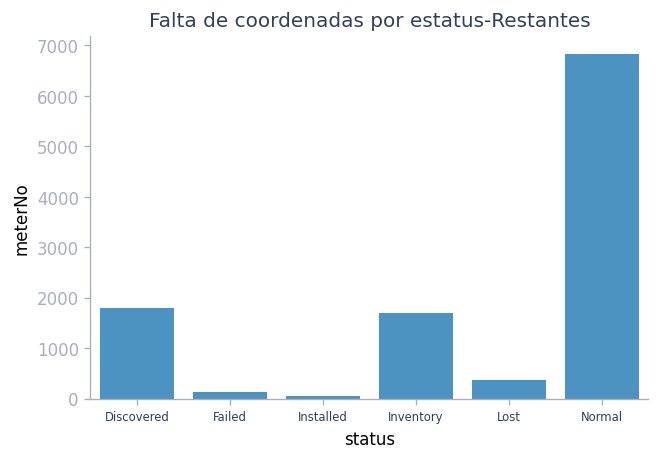

In [92]:
#Graficando por estatus
#sns.set_style("whitegrid")
plt.title("Falta de coordenadas por estatus-Restantes")
plt.xticks(fontsize=7, color = sClr3)
sns.barplot(remainNC[["status","meterNo"]].groupby("status").count().reset_index(),\
            x = "status", y = "meterNo", color = mClr)
plt.show()

Es notoria una disminución de los MC con estado "Inventory", lo que reduce la cantidad de MC sin coordenadas por el hecho de no estar desplegados en el terreno. 

Es posible que debido a la diferencia de tiempo entre el despliegue de un MC y el cambio de su estado en el sistema la información de fechas posteriores a la fecha de corte en el conjunto de datos provea de información adicional para completar pares de coordenadas vacías.

In [93]:
#Agregando información de fechas futuras
fDdf = pd.read_json("../Data/DataLake/cFiles/newestMC/meters-2023-06-30.json")
fMont = pd.read_excel("../Data/DataLake/cFiles/newestMC/09-06-2023-montaje.xlsx")

In [ ]:
#Agregando información de montaje a fDdf
fMont["fDate"] = pd.Timestamp("2023-06-09")

fMont.rename({"Número de serie":"meterNo","Status del sistema":"SStatus",\
                "Fecha de montaje":"mntDate","Fecha de desmontaje":"dmntDate",\
                "Válido de":"valido","Empl.equipo modif.el":"mod", "fDate":"fDate_mr"},\
                axis=1, inplace=True)
fDdf = fDdf.merge(fMont[["meterNo","SStatus","Lote","mntDate","dmntDate",\
                        "valido","mod","fDate_mr"]], on = "meterNo", how = "left")
fDdf.head(3)

In [ ]:
#Filtrando en rango de fechas de interés
print("Cantidad de filas de fDdf :", len(fDdf))
minDate = mCnCords["fDate"].min()
maxDate = mCnCords["fDate"].max()
mask = (fDdf["mntDate"] <= maxDate)|(fDdf["mntDate"] >= minDate)
fDdf = fDdf[mask]
#Eliminando Nans en latitud y longitud
fDdf = fDdf[~(fDdf["latitude"].isna() | fDdf["longitude"].isna())]
#Reteniendo MC sin coordenadas
fDdf = fDdf[fDdf["meterNo"].isin(mcWOC- mcIntersection)]
print("Cantidad de filas de fDdf luego del filtro :", len(fDdf))
fDdf.head(3)

In [ ]:
#Actualizando información de mCnCords
naMask = (mCnCords["latitude"].isna() | mCnCords["longitude"].isna())
print("MC sin coordenadas :", len(mCnCords[naMask].meterNo.unique()))
mCnCords = updateDf(mCnCords, fDdf, ["meterNo"], ["latitude","longitude","SStatus","Lote",\
                                    "mntDate","dmntDate","valido","mod","fDate_mr"])
fDataList = list(fDdf.meterNo.unique())
mCnCords.loc[mCnCords["meterNo"].isin(fDataList), "Comentario"] = "Fechas futuras"
mCnCords.to_csv("../Data/DataLake/temp/futureDates.csv", index = False)
naMask = (mCnCords["latitude"].isna() | mCnCords["longitude"].isna())
print("MC sin coordenadas después de actualización :", len(mCnCords[naMask].meterNo.unique()))
mCnCords.head(3)

<AxesSubplot: title={'center': 'Falta de coordenadas por estatus-Filtro'}, xlabel='status', ylabel='meterNo'>

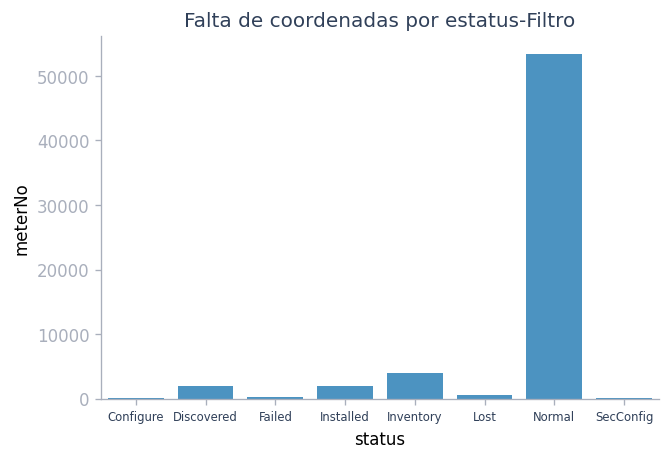

In [97]:
#Graficando por estatus
#sns.set_style("whitegrid")
plt.title("Falta de coordenadas por estatus-Filtro")
plt.xticks(fontsize=7, color = sClr3)
sns.barplot(mCnCords[["status","meterNo"]].groupby("status").count().reset_index(),\
            x = "status", y = "meterNo", color = mClr)

Existen dos fuentes externas más que pueden ser de utilidad, estas están referidas a los MC que son utilizados como repetidores y aquellos que se tiene referencia están instalados en un polo.

In [98]:
#Fuentes adicionales de coordenadas
rep = pd.read_csv("../Data/DataLake/cFiles/repetidoresMC.csv", usecols= [0,1,2,5,6], encoding='utf-8')
polMC1 = pd.read_csv("../Data/DataLake/cFiles/polesMC-1.csv", usecols = [0,3,4,5], encoding='utf-8')

In [99]:
#Renombrando
rep.rename({"Fecha instalación":"mntDate","Poste instalado":"poleNo","# Repetidor": "meterNo",\
            "Latitud":"latitude","Longitud":"longitude"}, axis=1, inplace=True)
polMC1.rename({"Poste":"poleNo","Latitud":"latitude","Longitud":"longitude","Medidor ":"meterNo"},\
            axis=1, inplace=True)

In [100]:
#Actualizando información de mCnCords
naMask = (mCnCords["latitude"].isna() | mCnCords["longitude"].isna())
#Convirtiendo llaves a string
#rep["meterNo"] = rep["meterNo"].astype(str)
#polMC1["meterNo"] = polMC1["meterNo"].astype(str)
naMC = mCnCords[naMask].meterNo.unique()
#Actualizando información de mCnCords
print("MC sin coordenadas antes de actualización :", len(mCnCords[naMask].meterNo.unique()))
mCnCords = updateDf(mCnCords, rep[rep["meterNo"].isin(naMC)], ["meterNo"], ["latitude","longitude","mntDate","poleNo"])
mCnCords.loc[mCnCords["meterNo"].isin(list(rep.meterNo.unique())), "Comentario"] = "Repetidor"
mCnCords = updateDf(mCnCords, polMC1[polMC1["meterNo"].isin(naMC)], ["meterNo"], ["latitude","longitude","poleNo"])
mCnCords.loc[mCnCords["meterNo"].isin(list(polMC1.meterNo.unique())), "Comentario"] = "PoloMC-1"
naMask = (mCnCords["latitude"].isna() | mCnCords["longitude"].isna()) & (mCnCords["Comentario"] == "")
tempF = mCnCords[naMask].copy()
print("MC sin coordenadas después de actualización :", len(tempF.meterNo.unique()))

MC sin coordenadas antes de actualización : 212


MC sin coordenadas después de actualización : 115


<AxesSubplot: title={'center': 'Falta de coordenadas por estatus-Final'}, xlabel='status', ylabel='meterNo'>

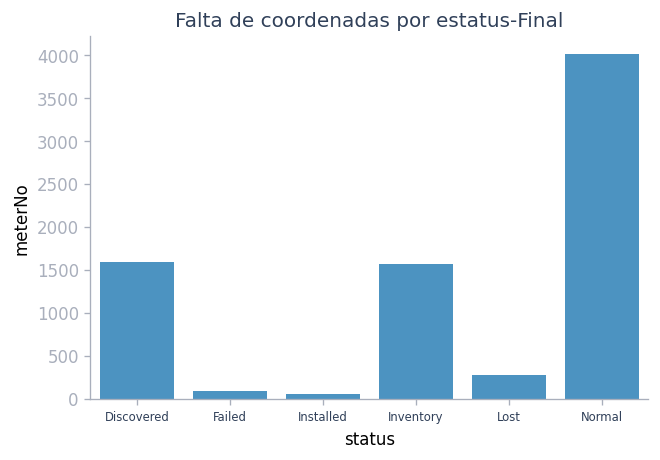

In [101]:
#Graficando por estatus
#sns.set_style("whitegrid")
plt.title("Falta de coordenadas por estatus-Final")
plt.xticks(fontsize=7, color = sClr3)
sns.barplot(tempF[["status","meterNo"]].groupby("status").count().reset_index(),\
            x = "status", y = "meterNo", color = mClr)


In [102]:
#Guardando mCnCords final
mCnCords.to_csv("../Data/DataLake/temp/mCnCords_Final.csv", index = False)

## Integración con df principal

In [ ]:
#Actualizando mContainer
naMask = (mContainer["latitude"].isna() | mContainer["longitude"].isna())
print("Cantidad de MC sin coordenadas :", len(mContainer[naMask].meterNo.unique()))
mContainer["Comentario"] = ""
mContainer = updateDf(mContainer, mCnCords, ["meterNo","fDate"], ["latitude","longitude","poleNo","Comentario"])
naMask = (mContainer["latitude"].isna() | mContainer["longitude"].isna())
#Agregando etiqueta de no desplegado en campo
mContainer.loc[mContainer["meterNo"].isin(mnService), "Comentario"] = "No desplegado"
mContainer.loc[mContainer["meterNo"].isin(intNC),"Comentario"] = "MC con coords"
#Coordenadas
partialC = mCnCords[mCnCords["Comentario"]=="Coordenadas parciales"].meterNo.unique()
mContainer.loc[mContainer["meterNo"].isin(partialC), "Comentario"] = "Coordenadas parciales"
tMask = (mContainer["latitude"].isna() | mContainer["longitude"].isna()) & \
            (mContainer["Comentario"] == "")
print("Cantidad de MC sin coordenadas después de actualización :", len(mContainer[tMask].meterNo.unique()))
mContainer.head(3)

In [104]:
mContainer.Comentario.unique()

array(['No desplegado', '', 'Coordenadas polo', 'Repetidor',
       'MC con coords', 'Coordenadas parciales', 'Fechas futuras',
       'PoloMC-1'], dtype=object)

In [105]:
#Cambiando formato
mContainer["latitude"] = pd.to_numeric(mContainer["latitude"], errors = "coerce")
mContainer["longitude"] = pd.to_numeric(mContainer["longitude"], errors = "coerce")
mContainer["poleNo"] = mContainer["poleNo"].astype(str)
mContainer.to_parquet("../Data/DataLake/cleaningStage/mContainer-c1.parquet")

In [106]:
#Agregando información de montaje a mContainer
montRef = montRef.sort_values(by = "fDate_mr", ascending = True)
mContainer = pd.merge_asof(mContainer,montRef.drop("fName", axis = 1), left_on = "fDate",\
                          right_on = "fDate_mr", by = "meterNo", suffixes = ("","_mr"), direction = "forward")#, by = "meterNo", direction = "nearest"

In [107]:
#Asignacion de columan de montaje
tmContainer = mContainer.copy()
tmContainer["Desplegado"] = ""
#Analizando casos particulares y cargando a nuevo df
trmContainer = pd.DataFrame(columns = tmContainer.columns)
#MC sin despliegue
tmContainer.loc[tmContainer["Comentario"] == "No desplegado", "Desplegado"] = "No"
trmContainer = trmContainer.append(tmContainer[tmContainer["Comentario"].isin(["No desplegado"])])
tmContainer = tmContainer[~tmContainer["Comentario"].isin(["No desplegado"])]
trmContainer.status.unique()

array(['Inventory'], dtype=object)

In [108]:
#Determinando montaje de acuerdo a fecha
tmContainer["mntDate"].fillna("NaD", inplace = True)
tmContainer["dmntDate"].fillna("NaD", inplace = True)
groupMont = tmContainer[["meterNo","mntDate","dmntDate","mod","fDate"]].\
    groupby(["meterNo","mntDate","dmntDate","mod"]).count()
groupMont = groupMont.reset_index()
groupMont["Changes"] = groupMont.groupby("meterNo")["fDate"].transform("count").\
    rename({"fDate":"rCount"})
groupMont.head(3)
groupMont.to_csv("../Data/DataLake/temp/groupMont.csv", index = False)

In [109]:
#Determinando asignación de montaje
groupMont['mntDate'] = pd.to_datetime(groupMont['mntDate'], errors='coerce')
groupMont['dmntDate'] = pd.to_datetime(groupMont['dmntDate'], errors='coerce')

#Diccionario de estados
state_dict = {}
for index, row in groupMont.iterrows():
    meter = row['meterNo']
    if meter not in state_dict:
        state_dict[meter] = {'montado': [], 'desmontado': []}
    
    state_dict[meter]['montado'].append(row['mntDate'])
    if row['dmntDate'] is not pd.NaT:
        state_dict[meter]['desmontado'].append(row['dmntDate'])

#Ordenando fechas
for meter, dates in state_dict.items():
    dates['montado'].sort()
    dates['desmontado'].sort()

In [110]:
#Aplicando función para determinar el estado
tmContainer['fDate'] = pd.to_datetime(tmContainer['fDate'], errors='coerce')

def assign_state(meter, f_date):
    montado_dates = state_dict.get(meter, {}).get('montado', [])
    desmontado_dates = state_dict.get(meter, {}).get('desmontado', [])
    #Ultimo estado
    last_mnt_date = max([date for date in montado_dates if date <= f_date], default=None)
    last_dmnt_date = max([date for date in desmontado_dates if date <= f_date], default=None)
    #Condicional
    if last_mnt_date is None:
        return 'No'
    if last_dmnt_date is None or last_mnt_date > last_dmnt_date:
        return 'Sí'
    else:
        return 'No'

#Aplicando a tmContainer
tmContainer['Desplegado'] = tmContainer.apply(lambda x: assign_state(x['meterNo'], x['fDate']), axis=1)

In [111]:
tmContainer = tmContainer.append(trmContainer, ignore_index=True)

In [112]:
#Confirmando shape
tmContainer.shape

(1733505, 27)

In [113]:
#Rellenando segun registros con información
tMcs = tmContainer[tmContainer["Comentario"].isin(["MC con coords","Coordenadas parciales"])]\
    ["meterNo"].unique()
mask = tmContainer["meterNo"].isin(tMcs) & tmContainer["Desplegado"].isin(["Sí"])
tempCo = tmContainer[mask]
tempCo.sort_values(by = ["meterNo","fDate"], ascending = [True, True], inplace = True)
tempCo.to_csv("../Data/DataLake/temp/tempCo.csv", index = False)
#Imputando valores
#Forward
tempCo["latitude"] = tempCo.groupby("meterNo")["latitude"].fillna(method='ffill')
tempCo["longitude"] = tempCo.groupby("meterNo")["longitude"].fillna(method='ffill')
tempCo["poleNo"] = tempCo.groupby("meterNo")["poleNo"].fillna(method='ffill')
#Backward
tempCo["latitude"] = tempCo.groupby("meterNo")["latitude"].fillna(method='bfill')
tempCo["longitude"] = tempCo.groupby("meterNo")["longitude"].fillna(method='bfill')
tempCo["poleNo"] = tempCo.groupby("meterNo")["poleNo"].fillna(method='bfill')
tempCo.to_csv("../Data/DataLake/temp/tempCo2.csv", index = False)

#Actualizando tmContainer
tmContainer = tmContainer[~mask]
tmContainer = tmContainer.append(tempCo, ignore_index=True)
len(tmContainer)

1733505

In [114]:
#Agregando información de rep y polMC1 a df principal
naMask = (rep["latitude"].isna() | rep["longitude"].isna())
rep = rep[~naMask]
rep["Comentario"] = "Repetidor"
naMask = (polMC1["latitude"].isna() | polMC1["longitude"].isna())
polMC1 = polMC1[~naMask]
polMC1["Comentario"] = "PoloMC-1"
#Obteniendo MC en común
tMcs = list(rep.meterNo.unique()) + list(polMC1.meterNo.unique())
mask = tmContainer["meterNo"].isin(tMcs) & tmContainer["Desplegado"].isin(["Sí"])
#Actualizando información de tmContainer
tempCo2 = updateDf(tmContainer[mask], rep,["meterNo"], ["latitude","longitude","poleNo","Comentario"])
tempCo2 = updateDf(tempCo2, polMC1, ["meterNo"], ["latitude","longitude","poleNo","Comentario"])
#Actualizando df principal
tmContainer = tmContainer[~mask]
tmContainer = tmContainer.append(tempCo2, ignore_index=True)
len(tmContainer)

1733505

In [115]:
#Cantidad final sin coordenadas
naMask = (tmContainer["latitude"].isna() | tmContainer["longitude"].isna()) &\
    tmContainer["Desplegado"].isin(["Sí"])
len(tmContainer[naMask].meterNo.unique())
#Agregando comentario
tmContainer.loc[naMask, "Comentario"] = "No desplegado"

<AxesSubplot: title={'center': 'Falta de coordenadas por estatus-Df final'}, xlabel='status', ylabel='meterNo'>

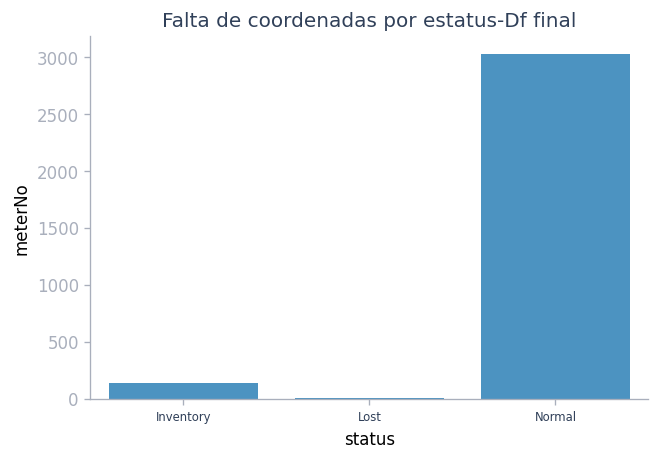

In [116]:
#Graficando por estatus
#sns.set_style("whitegrid")
plt.title("Falta de coordenadas por estatus-Df final")
plt.xticks(fontsize=7, color = sClr3)
sns.barplot(tmContainer[naMask][["status","meterNo"]].groupby("status").count().reset_index(),\
            x = "status", y = "meterNo", color = mClr)


In [117]:
#Final mnoCords
mnoCords = tmContainer[naMask].copy()
mnoCords.to_csv("../Data/DataLake/temp/mnoCords.csv", index = False)

## Determinando outliers con ML

Llegados a este punto solo queda la posibilidad de coordenadas erróneas, debido a la cantidad de datos se abordará el problema utilizando Isolation Forest, un algoritmo de aprendizaje de máquina que crea un busque de árboles de decisión que van segmentando los datos según ciertas condicionantes, a diferencia de otros algoritmos como Random Forest, el objetivo de este es aislar a los registros menos comunes del conjutno de datos.

In [118]:
#tmContainerBK = tmContainer.copy()
#tmContainer = tmContainerBK.copy()

In [119]:
tmContainer.astype({"CollectorNm":str})
cContainer.astype({"CollectorNm":str})
cContainer["fDate"] = pd.to_datetime(cContainer["fDate"])

In [120]:
#Merge de cContainer
tmContainer = tmContainer.merge(cContainer[["CollectorNm", "fDate", "latitude", "longitude"]],\
                on = ["CollectorNm","fDate"], suffixes = ('','_gw'), how = "left")

In [121]:
#Codificando CollectorNm por frecuencia según ronda
tmContainer["CollectorNm"] = tmContainer["CollectorNm"].astype(str)
frequencies = tmContainer["CollectorNm"].value_counts(normalize=True)
tmContainer["CollectorFreq"] = tmContainer["CollectorNm"].map(frequencies)

In [ ]:
#Mascara para montados con coordenadas
mask = tmContainer["Desplegado"].isin(["Sí"]) & (~tmContainer["latitude"].isna() &\
                ~tmContainer["longitude"].isna())
tdf = tmContainer.loc[mask,["meterNo","CollectorNm","round","CollectorFreq","latitude",\
                "longitude", "layer","fDate", "latitude_gw","longitude_gw"]]

#Calculando distancia entre coordenadas
tdf["Gw_dist"] = tmContainer.apply(lambda x: cord2disV2(x["latitude"],x["longitude"],\
                x["latitude_gw"],x["longitude_gw"]), axis = 1)

tdf.dropna(inplace = True)
tdf.head(3)

In [ ]:
#Aplicando Isolation Forest
clf = IsolationForest(n_estimators=100, max_samples='auto',contamination=float(0.02),\
                    random_state=1010)
X = tdf[["CollectorFreq","latitude","longitude", "Gw_dist"]].copy()
#Entrenando modelo
clf.fit(X)
#Prediciendo

tdf["scores"] = clf.decision_function(X)
tdf["anomaly"] = clf.predict(X)
mapper = {1: "Normal", -1: "Anomaly"}
tdf["anomaly"] = tdf["anomaly"].map(mapper)
tdf.head(3)


In [124]:
#Guardando modelo
from joblib import dump, load
dump(clf, '../Models/IForest_4_last.joblib')


['../Models/IForest_4_last.joblib']

In [ ]:
tdf[tdf["anomaly"] == "Anomaly"].to_csv("../Data/DataLake/temp/anomalies4.csv", index = False)
tdf[tdf["anomaly"] == "Anomaly"].head(3)

In [126]:
#Visualización de todos los equipos
#Widgets
fDate5 = widgets.SelectionSlider(options = list(tdf["fDate"].unique()), description = "Fecha")
mgatewayS = widgets.Dropdown(options = sorted(list(cContainer["CollectorNm"].unique())),description = "Collector")
clrDic4 = {"Anomaly": sClr1, "Normal": sClr3}
#clrDic3 = {True: sClr1, False: sClr3}
wgDic6 = {"fDate":fDate5, "CollectorNm" : mgatewayS}#"fDate":fDate4, 
dicTemp5 = {
    "vecino" : [tdf, clrDic4, "anomaly",["meterNo"],["latitude","longitude"]],
    "CollectorNm" : [tdf, sClr4, None,["CollectorNm"],["latitude_gw","longitude_gw"]]
}

In [127]:
#Visualización de mapa interactivo
Rdiscrete_map3(dicTemp5, wgDic6, "Mesh Clientes Anómalos_4")

Output()

interactive(children=(SelectionSlider(description='Fecha', options=(numpy.datetime64('2023-02-19T00:00:00.0000…

## Corrigiendo coordenadas

In [ ]:
#Creando columna
tmContainer["anomaly"] = ""
tmContainer["Gw_dist"] = ""
#Actualizando tmContainer
print("Len de tmContainer antes de actualización :", len(tmContainer))
tdf["Gw_dist"] = tdf["Gw_dist"].astype(str)
tmContainer = updateDf(tmContainer, tdf[["meterNo","fDate","anomaly", "Gw_dist"]], ["meterNo", "fDate"],\
                    ["anomaly","Gw_dist"])
print("Len de tmContainer después de actualización :", len(tmContainer))
tmContainer.head(3)

In [ ]:
#Seleccionando MC anómalos
mask = tmContainer["anomaly"] == "Anomaly"
anomalies = tmContainer[mask]
anomalies.head()

In [ ]:
#Calculando distancia con referencia a polo
#Aplicando regex de polo
anomalies["poleNo"].str.extract(r"([0-9]{6})")

anomalies = anomalies.merge(polesCords[["poleNo","latitude","longitude"]], on = "poleNo", \
                how = "left", suffixes = ("","_pl"))

anomalies["pole_gw"] = anomalies.apply(lambda x: cord2disV2(x["latitude_gw"],x["longitude_gw"],\
                x["latitude_pl"],x["longitude_pl"]), axis = 1)

#Comparando distancias
anomalies["distComparation"] = anomalies["Gw_dist"].astype(float) - anomalies["pole_gw"].astype(float)
#Volviendo etiqueta
anomalies["fixed"] = anomalies["distComparation"].apply(lambda x: "Fixed" if x > 0 else "No Fixed")
anomalies.to_csv("../Data/DataLake/temp/anomalies.csv", index = False)
anomalies.head(3)

In [131]:
#Visualizando anomalías
#Widgets
fDate6 = widgets.SelectionSlider(options = list(anomalies["fDate"].unique()), description = "Fecha")
mgatewayS = widgets.Dropdown(options = sorted(list(anomalies["CollectorNm"].unique())),description = "Collector")
clrDic5 = {"Fixed": sClr1, "No Fixed": sClr3}
#clrDic3 = {True: sClr1, False: sClr3}
wgDic7 = {"fDate":fDate5, "CollectorNm" : mgatewayS}#"fDate":fDate4, 
dicTemp2 = {
    "PrevCords" : [anomalies, sClr2, None, ["meterNo"],["latitude","longitude"]],
    "MeshClients" : [anomalies, clrDic5, "fixed",["meterNo"],["latitude_pl","longitude_pl"]],
    "CollectorNm" : [anomalies, sClr4, None,["CollectorNm"],["latitude_gw","longitude_gw"]]
}



In [132]:
#Visualización de mapa interactivo
Rdiscrete_map3(dicTemp2, wgDic7, "Coordenadas corregidas")

Output()

interactive(children=(SelectionSlider(description='Fecha', options=(numpy.datetime64('2023-02-19T00:00:00.0000…

In [133]:

anomalies.loc[anomalies["fixed"] == "Fixed", "latitude"] = anomalies.loc\
            [anomalies["fixed"] == "Fixed","latitude_pl"]
anomalies.loc[anomalies["fixed"] == "Fixed", "longitude"] = anomalies.loc\
            [anomalies["fixed"] == "Fixed","longitude_pl"]
anomalies.to_csv("../Data/DataLake/temp/anomalies.csv", index = False)

In [134]:
#Actualizando tmContainer
print("Len de tmContainer antes de actualización :", len(tmContainer))
tmContainer["fixed"] = ""
#Aplicando update
tmContainer = updateDf(tmContainer, anomalies[["meterNo","fDate","fixed", "latitude", "longitude"]], ["meterNo", "fDate"],\
                    ["fixed"])

Len de tmContainer antes de actualización : 1733505


In [135]:
tmContainer[tmContainer["anomaly"] == "Anomaly"].to_csv("../Data/DataLake/temp/anomaliesfinal2.csv",\
                        index = False, encoding = 'latin-1')

In [136]:
tmContainer["poleNo"] = tmContainer["poleNo"].astype(str)
tmContainer["mntDate"] = pd.to_datetime(tmContainer["mntDate"],  errors = 'coerce')
tmContainer["dmntDate"] = pd.to_datetime(tmContainer["dmntDate"],  errors = 'coerce')

In [137]:
tmContainer.to_parquet("../Data/DataMart/Base/mContainer.parquet")
tmContainer.to_csv("../Data/DataMart/Base/mContainer.csv", index = False, encoding='latin-1')